In [1]:
from FileUtils import FileUtils
import matplotlib.pyplot as plt 
import os
import torch
from Settings import Settings
from ReplayMemory import Transition, ReplayMemory

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [ ]:
data = FileUtils(100)
data.filter_by_class("cat")

In [ ]:
from Agent import Agent

In [ ]:
agent = Agent(data.images[0])
print(agent.history)
agent.hierarchical_move(5)
agent.update_history_vector(5)
print(agent.history)
print(agent.history)
agent.hierarchical_move(1)
agent.update_history_vector(1)
print(agent.history)
print(agent.history)
agent.hierarchical_move(3)
agent.update_history_vector(3)
print(agent.history)
print(agent.history)
agent.hierarchical_move(2)
agent.update_history_vector(2)
print(agent.history)

In [ ]:
memo = ReplayMemory(10)

In [ ]:
from Models import QModel

In [ ]:
q_model = QModel()

In [ ]:
for i in range(20):
    memo.push(agent.get_state(), agent.get_next_action(q_model, 0.5), agent.get_state(), torch.tensor(1))
    memo.push(agent.get_state(), agent.get_next_action(q_model, 0.5), None, torch.tensor(3))

In [ ]:
transitions = memo.sample(5)

In [ ]:
transitions

In [ ]:
batch = Transition(*zip(*transitions))

In [ ]:
print(batch)

In [ ]:
def use_cuda(tensor, cuda=Settings.cuda):
    if cuda:
        tensor = tensor.cuda()
    return tensor


In [ ]:
non_finals = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool)
non_finals = use_cuda(non_finals)
non_finals

In [ ]:

next_states = [s for s in batch.next_state if s is not None]
non_final_next_states = torch.cat(next_states).type(torch.float)
non_final_next_states = use_cuda(non_final_next_states)

non_final_next_states.shape

In [ ]:
state_batch = torch.cat(batch.state).type(torch.float)
state_batch = use_cuda(state_batch)
state_batch.shape

In [ ]:
from torch.autograd import Variable

In [ ]:
action_batch = torch.tensor(batch.action, dtype=torch.long).view(-1, 1)
action_batch = use_cuda(action_batch)

In [ ]:
action_batch

In [ ]:
reward_batch = torch.tensor(batch.reward, dtype=torch.float).view(-1, 1)
reward_batch = use_cuda(reward_batch)

In [ ]:
reward_batch

In [ ]:
 a = q_model(state_batch)

In [ ]:
a

In [ ]:
state_action_values = a.gather(1, action_batch - 1) 

In [ ]:
state_action_values

In [ ]:
a.max(1)[0].view(-1, 1)

In [ ]:
action_batch

In [ ]:
next_state_values = torch.zeros(5)
next_state_values = use_cuda(next_state_values)

next_state_values[non_finals] = q_model(non_final_next_states).max(1)[0].detach()
next_state_values.view(-1, 1)

In [ ]:
next_state_values = next_state_values.view(-1, 1)

In [ ]:
expected_state_action_values = (next_state_values * Settings.gamma) + reward_batch


In [ ]:
expected_state_action_values

In [ ]:
state_action_values.shape

In [ ]:
import torch.nn.functional as F

In [30]:
from FileUtils import FileUtils
import matplotlib.pyplot as plt 

data = FileUtils(1000)
data.filter_by_class("bird")

Start to load data
Start to load images: 1000=>1000!
Start to load annotations: 1000=>1000!
End


In [31]:
from Models import QModel
from Settings import Settings
import torch
import torch.optim as optim
import time
from Agent import Agent
from IoU import *
from TrainUtils import optimize_model
import json
device = torch.device("cuda" if Settings.cuda else "cpu")

Step 0=>current iou = 0.055744 || current action = 4 || current reward = 1.0
Step 1=>current iou = 0.06219160682006937 || current action = 2 || current reward = 1.0
Step 2=>current iou = 0.10209319111396263 || current action = 5 || current reward = 1.0
Step 3=>current iou = 0.0565149136577708 || current action = 1 || current reward = -1.0
Step 4=>current iou = 0.10937974738486912 || current action = 3 || current reward = 1.0
Step 5=>current iou = 0 || current action = 4 || current reward = -1.0
Step 6=>current iou = 0 || current action = 4 || current reward = -1.0
Step 7=>current iou = 0 || current action = 3 || current reward = -1.0


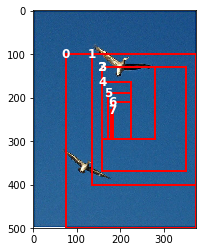

In [47]:
target_model = QModel()
target_model.load_state_dict(torch.load("{}model_30.pt".format(Settings.model_path)))

if Settings.cuda:
    target_model.cuda()
target_model.eval()


from Image import Image
image = Image(data,6)
annotation_list = image.objects
agent = Agent(image.image)
done = False
old_iou_list = None
state_list = list()

for step in range(Settings.max_step):
    print("Step {}".format(step), end="=>")
    

    iou_list = [iou_calculator(agent.boundary, x) for x in annotation_list]
    max_index = max(range(len(iou_list)), key=lambda x: iou_list[x])
    iou = max(iou_list)
    
    print("current iou = {}".format(iou), end=" || ")
    old_iou = old_iou_list[max_index] if old_iou_list else 0
    old_iou_list = iou_list

    cur_state = agent.get_state()
    state_list.append(cur_state)

    # determine if we should end the result 
    if iou > Settings.iou_threshold:
        action = torch.tensor(6).to(device)
        done = True
    else:
        action = agent.get_next_action(target_model, eps=0)
#         action = 5

    if action == 6:
        reward = reward_terminal(iou)
        done = True

    else:
        agent.hierarchical_move(action)
        agent.update_history_vector(action)
        image.draw_one_box(agent.boundary)
        image.add_text(step, (agent.boundary["xmin"], agent.boundary["ymin"]))
        if agent.sub_image.shape[0] * agent.sub_image.shape[1] == 0:
            done = True
        else:
            reward = reward_move(old_iou, iou)
            
    print("current action = {}".format(int(action)), end=" || ")
    print("current reward = {}".format(float(reward)))
    if done:
        break
image.show()    

In [ ]:
for s in state_list:
    for i, x in enumerate(s[0]):
        if not x == 0:
            print(i)